# Ms. Pac Man with Deep Reinforcement Learning
### Mark Lisi, CPSC 458



In [1]:
# %pip install atari-py

In [28]:
import gym
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, initializers
from collections import deque
import numpy as np



https://towardsdatascience.com/advanced-dqns-playing-pac-man-with-deep-reinforcement-learning-3ffbd99e0814

We first examine our action space and observation space - we can take one of 9 actions at any time, and the input will be a 210x160 color frame. The agent will learn simply from looking at what's on the screen - much like a human player would.

In [3]:
env = gym.make("ALE/MsPacman-v5", render_mode='human')
print("Action space:", env.action_space)
print("Observation space:", env.observation_space)

Action space: Discrete(9)
Observation space: Box(0, 255, (210, 160, 3), uint8)


Our 9 available actions are:

0 - NOOP (no action)

1 - UP

2 - RIGHT

3 - LEFT

4 - DOWN

5 - UPRIGHT (diagonal input, like a joystick)

6 - UPLEFT

7 - DOWNRIGHT

8 - DOWNLEFT

We can set up some constants based on our actions and observations:

Let's look at our environment - looks like Pac Man!

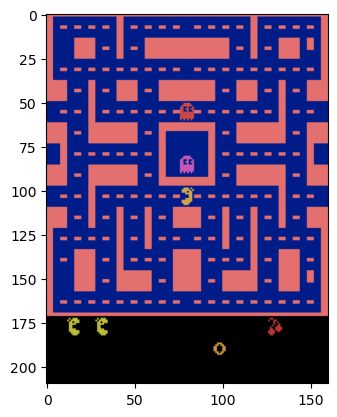

In [12]:
observation, info = env.reset(seed=42)
plt.imshow(observation)

We can see how the agent performs with random actions. (Gameplay visible in a separate window)

In [14]:
import time

observation, info = env.reset(seed=42)
for _ in range(300):
    observation, reward, terminated, truncated, info = env.step(env.action_space.sample())

    if terminated or truncated:
        observation, info = env.reset()

env.close()

Now we can explain our approach to training this agent. We will first create a model that takes a frame as an input (210x160x3 tensor) and returns an action (one-hot 9-dimensional vector). We'll train this model to maximize reward

In [19]:
state = layers.Input(shape=observation.shape)

layer1 = layers.Conv2D(filters = 32, kernel_size=(5,5), strides=4, activation="relu",
                    kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                    bias_initializer=initializers.Constant(0.01))(state)
layer2 = layers.MaxPool2D(2, strides=2, padding="SAME")(layer1)
layer3 = layers.Conv2D(filters=64, kernel_size=4, strides=2, activation="relu", 
                    kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                    bias_initializer=initializers.Constant(0.01))(layer2)
layer4 = layers.Flatten()(layer3)
q_value = layers.Dense(units=9, activation="linear", 
                    kernel_initializer=initializers.TruncatedNormal(mean=0., stddev=0.01),
                    bias_initializer=initializers.Constant(0.01))(layer4)

model = keras.Model(inputs=state, outputs=q_value)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 210, 160, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 52, 39, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 20, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 9, 64)         32832     
                                                                 
 flatten_2 (Flatten)         (None, 6912)              0         
                                                                 
 dense_2 (Dense)             (None, 9)                 62217     
                                                           

We're now ready to implement the Deep Q-learning algorithm. Deep Q-Learning (DQL) is a reinforcement learning technique that combines Q-learning with deep neural networks to approximate the optimal action-value function. It learns to make decisions by iteratively updating its estimates of the Q-values, which represent the expected cumulative reward for taking a particular action in a given state. We will store game history to make decisions.

The update rule for Q learning is

$$Q(s,a) \leftarrow Q(s,a) + \alpha (r(s,a) + \gamma\cdot \max_{a'} Q(\text{next}(s,a), a') - Q(s,a))$$

where $\gamma$ is the discount factor and $\alpha$ can be viewed as the step size or learning rate for gradient ascent.

We initialize these hyperparameters and a few others:

In [49]:
gamma = 0.99            # decay rate of past observations
step_size = 1e-4        # step size
observe = 100           # timesteps to observe before training
replay_memory = 5000    # number of previous transitions to remember
batch_size = 32         # size of each batch
epsilon = 0.1           # random exploration factor; higher = more random

Finally, we can begin the training loop. We'll need to play a lot of Pac Man to train this model - to speed things up, we won't render the gameplay.

In [58]:
env = gym.make("ALE/MsPacman-v5") # no render mode specified
history_data = deque()


observation, info = env.reset(seed=42)
n_actions = env.action_space.n
loss_function = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=step_size, clipnorm=1.0)

t = 0
while t < 50000:
    if epsilon > np.random.rand(1)[0]:
        # random action - exploration
        action = np.random.choice(n_actions)
    else:
        # greedy action - exploitataion
        current_state_tensor = tf.convert_to_tensor(observation)
        current_state_tensor = tf.expand_dims(current_state_tensor, 0)
        q_value = model(current_state_tensor, training=False)
        action = np.argmax(q_value[0])

    # take the action and observe the reward and the next state
    next_observation, reward, terminated, truncated, info = env.step(action)

    # store the observation
    history_data.append((observation, action, reward, next_observation, terminated))
    if len(history_data) > replay_memory:
            history_data.popleft()  # discard old data
    
    # train if done observing
    if t > observe:

        # sample a batch
        batch = random.sample(history_data, batch_size)
        state_sample = np.array([d[0] for d in batch])
        action_sample = np.array([d[1] for d in batch])
        reward_sample = np.array([d[2] for d in batch])
        state_next_sample = np.array([d[3] for d in batch])
        terminal_sample = np.array([d[4] for d in batch])

        # compute the updated Q-values for the samples
        updated_q = model.predict(state_next_sample)
        updated_q_value = (reward_sample * terminal_sample) + (1-terminal_sample) * (reward_sample + gamma * tf.reduce_max(updated_q, axis=1))

        ''' ^ a little confusing, but boils down to this:
        if terminal_sample:
            (reward_sample * terminal_sample)
        else:
            (reward_sample + gamma * tf.reduce_max(updated_q, axis=1))
        '''
        #-----------------#

        # train the model on the states and updated Q-values
        with tf.GradientTape() as tape:
            # compute the current Q-values for the samples
            #-----------------#
            current_q = model(state_sample)
            action = tf.one_hot(action_sample, n_actions)
            current_q_value = tf.reduce_sum(tf.multiply(current_q, action), axis=1)
            #-----------------#

            # compute the loss
            loss = loss_function(updated_q_value, current_q_value)

        # backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    else:
        loss = 0

    # update current state and counter
    observation = next_observation
    t += 1


    

    

1/1 [==============================] - 0s 30ms/step


KeyboardInterrupt: 

In [54]:
observation, info = env.reset(seed=42)

current_state_tensor = tf.convert_to_tensor(observation)
current_state_tensor = tf.expand_dims(current_state_tensor, 0)
q_value = model(current_state_tensor, training=False)
action = np.argmax(q_value[0])

next_observation, reward, terminated, truncated, info = env.step(action)




1

In [60]:
env = gym.make("ALE/MsPacman-v5", render_mode='human')
observation, info = env.reset(seed=42)

for _ in range(1000):
    
    current_state_tensor = tf.convert_to_tensor(observation)
    current_state_tensor = tf.expand_dims(current_state_tensor, 0)
    q_value = model(current_state_tensor, training=False)
    action = np.argmax(q_value[0])

    next_observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()

env.close()

: 